<a href="https://colab.research.google.com/github/2unnifemi/portfolio/blob/main/Meal_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mealy Recommendation App: Model Creation
In this project, we will be developing a meal recommendation app called Mealy. Mealy aims to provide a user-friendly platform for users to order their favorite meals and drinks from local restaurants and cafes. The app will facilitate online ordering, making it convenient and efficient for both customers and partnering businesses.
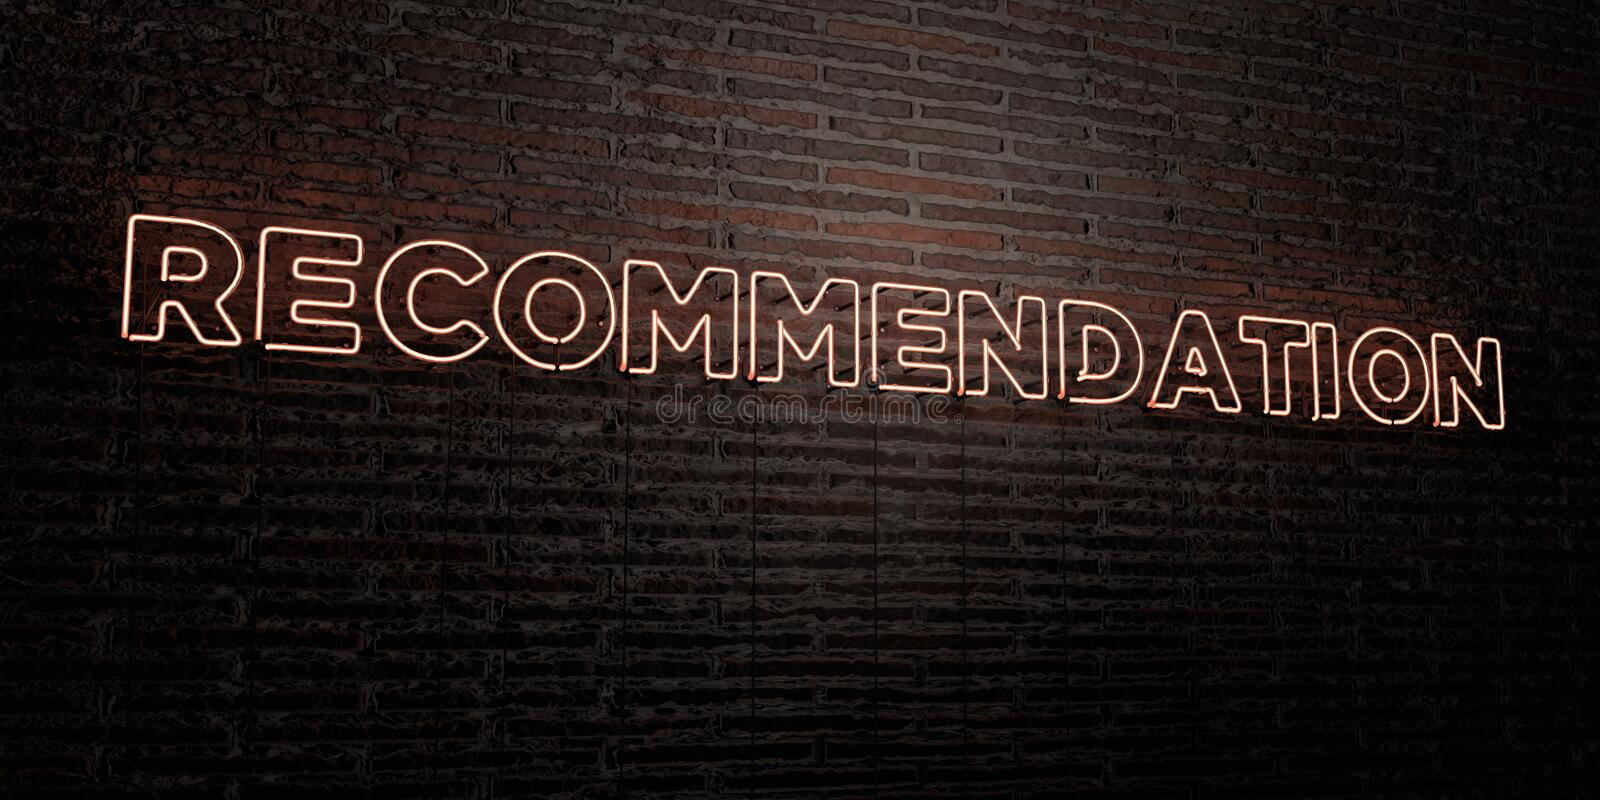

### Business Objectives
The primary business objective of Mealy is to create an online ordering system that benefits local restaurants and cafes by helping them reach a wider audience and increase their sales. By providing a seamless user experience, Mealy aims to increase user engagement and retention, which can ultimately lead to increased revenue.

### Dataset Overview
The dataset was created using a combination of panda,faker and numpy libraries to create a dataset with the following characteristics:
- user_id: what customer made the order
- food_name: Name of food the customer bought
- food_category: what category the food bought belongs to an the restaurants menu
- food_price: how much the food ordered cost
- Restaurant: what restaurant the customer ordered from
- Restaurant category: what category of Restaurant
- Rating: what rating the customer gave the meal
- food_description: the description on the meal ordered
- restaurant_location: where the restaurant is at

## Data Exploration
In this section, we will explore the  dataset, restaurantsdata.csv, to gain a better understanding of their structure, contents, and quality. We will start by importing the necessary libraries, reading the data, and performing initial exploratory analysis.

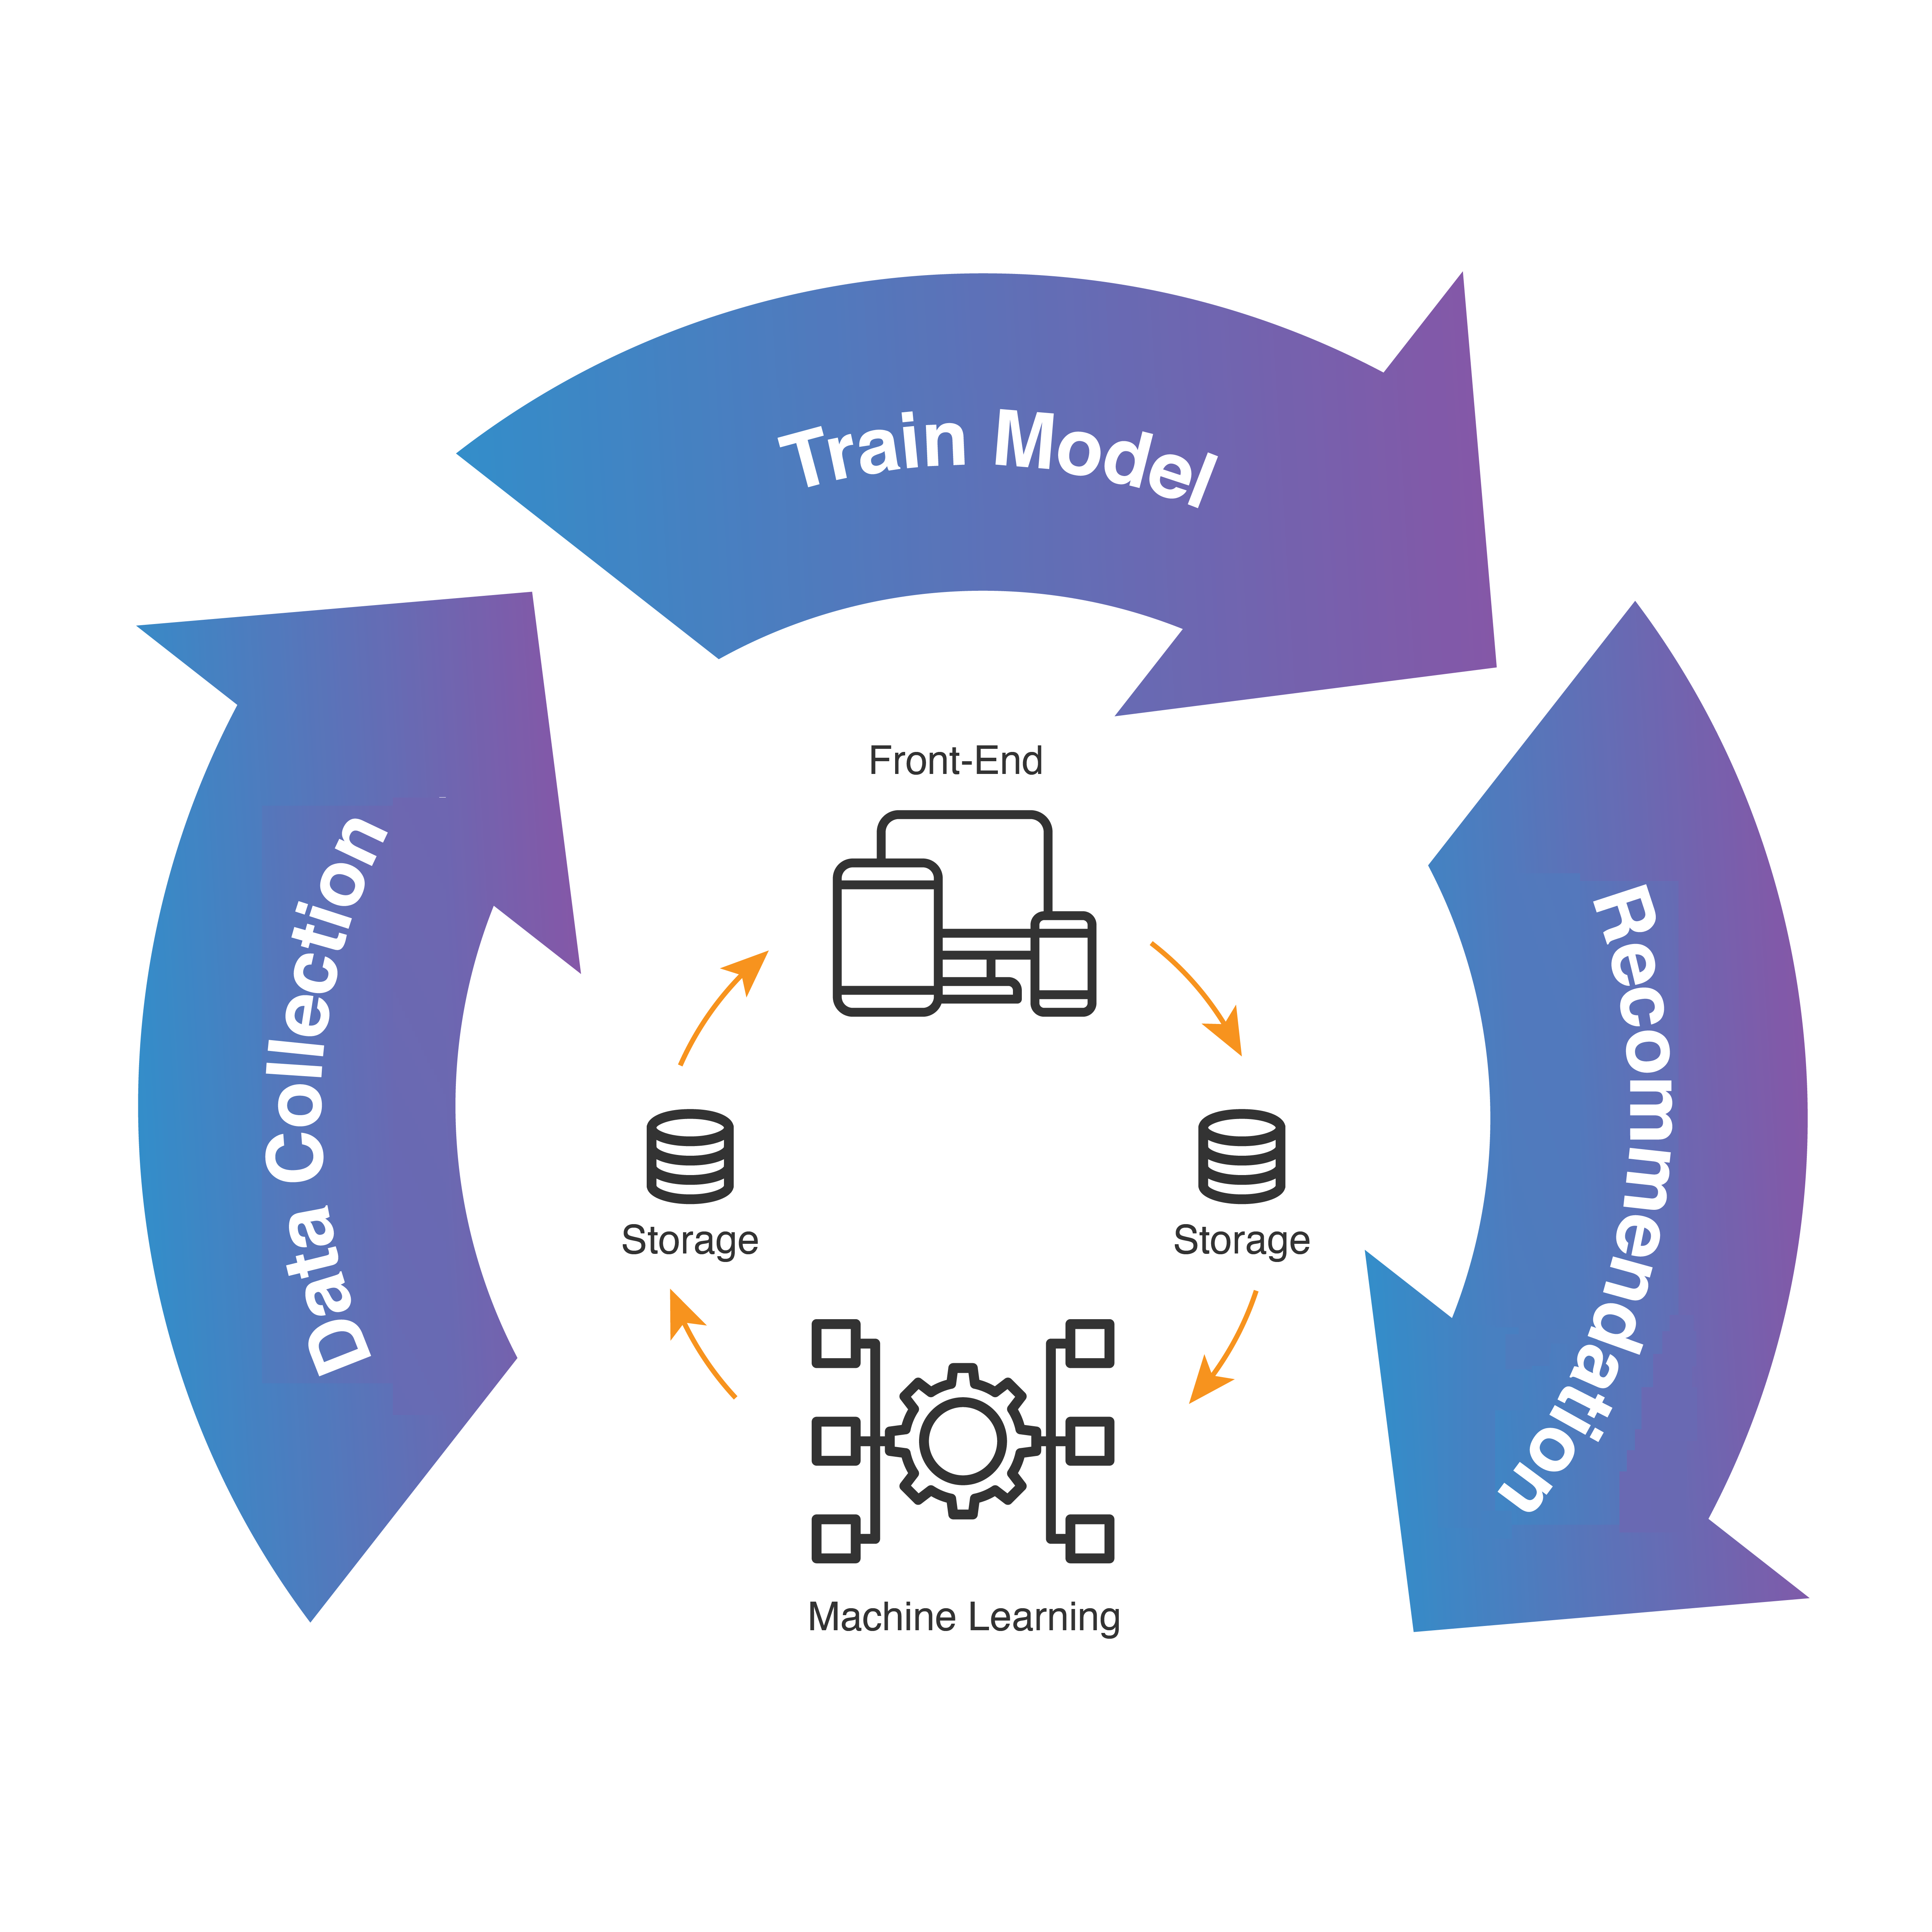

#### Loading the Data
Next, we will load the CSV files restaurants.csv and restaurant-menus.csv into our Python environment using the pandas library:

#### Importing the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity


from surprise import Reader, Dataset, SVD,accuracy
from surprise.model_selection import cross_validate

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [ ]:
# Load the restaurant menus dataset
restaurant_df = pd.read_csv('restaurant_datas.csv')

restaurant_df.tail(5)

,User_ID,Food_name,Restaurant_Name,Food_Price,Restaurant_Category,Rating,Food_Description,Restaurant_Location
1495,410347,Jollof Rice with Fried Plantain,Shiro Restaurant & Bar,3500,Nigerian,1.0,A classic Nigerian dish made with flavorful ri...,Victoria Island
1496,410417,Spicy Chicken Burger,Chicken Republic,1000,Fast Food,5.0,This burger is made with a chicken patty that ...,Oniru
1497,410400,Chicken Alfredo,KFC,4000,Fast Food,4.0,"Chicken in a creamy Alfredo sauce, served over...",Oshodi
1498,410180,BBQ Ribs with Coleslaw,Hard Rock Cafe,10000,American,3.5,Tender and succulent pork ribs basted in tangy...,Victoria Island
1499,410329,Pancakes,Hearth Cloud Kitchen And Cafe,1500,Breakfast,1.0,A popular breakfast dish made with fluffy panc...,Dolphin Estate


In [ ]:
restaurant_df[restaurant_df['User_ID']==410400]

,User_ID,Food_name,Restaurant_Name,Food_Price,Restaurant_Category,Rating,Food_Description,Restaurant_Location
509,410400,Moi Moi,Alara,1000,"Nigerian, Fine Dining",4.5,Moi Moi is a savory Nigerian steamed bean pudd...,Lekki
1034,410400,Green Curry,Orchid House Thai Restaurant,3200,Thai,4.0,Thai curry that is made with green chili peppe...,Victoria Island
1208,410400,BBQ Ribs with Coleslaw,Hard Rock Cafe,10000,American,3.5,Tender and succulent pork ribs basted in tangy...,Victoria Island
1497,410400,Chicken Alfredo,KFC,4000,Fast Food,4.0,"Chicken in a creamy Alfredo sauce, served over...",Oshodi


##### Restaurants Dataset
Let's start by examining the structure and contents of the restaurants_df dataframe:
### Data Cleaning

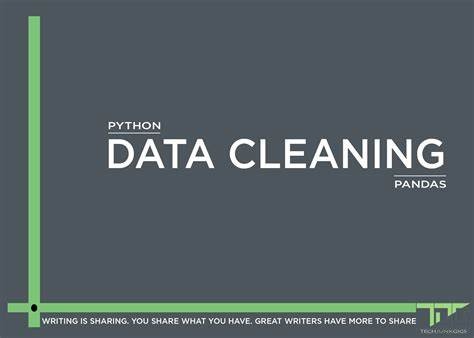

In [ ]:
# Get general information about the restaurants dataset
restaurant_df.info()

# Summary statistics of the numeric columns
restaurant_df.describe()

# Dimensions of the dataset
restaurant_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   User_ID              1500 non-null   int64  
 1   Food_name            1500 non-null   object 
 2   Restaurant_Name      1500 non-null   object 
 3   Food_Price           1500 non-null   int64  
 4   Restaurant_Category  1500 non-null   object 
 5   Rating               1500 non-null   float64
 6   Food_Description     1500 non-null   object 
 7   Restaurant_Location  1500 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 93.9+ KB


(1500, 8)

#### Data Cleaning: Dropping Duplicates and Checking for Null Values
In the data cleaning step, we will handle any data quality issues such as duplicate records and missing values. This ensures the accuracy and reliability of our analysis. Let's start by addressing duplicates and checking for null values in the datasets.

#### Dropping Duplicates
Duplicate records can skew our analysis and produce inaccurate results. We will identify and remove any duplicate entries from the datasets.

In [ ]:
# Check for duplicate rows in the restaurant menus dataset
duplicate_restaurants = restaurant_df.duplicated()
print("Number of duplicate rows in the restaurant dataset:", duplicate_restaurants.sum())

Number of duplicate rows in the restaurant dataset: 5


#### Checking for Null Values
Null values can impact our analysis and introduce inconsistencies. Let's check for any missing values in the datasets.

In [ ]:
restaurant_df['User_ID'].nunique()

472

In [ ]:
# Check for null values in the restaurants dataset
restaurant_df.isnull().sum()

User_ID                0
Food_name              0
Restaurant_Name        0
Food_Price             0
Restaurant_Category    0
Rating                 0
Food_Description       0
Restaurant_Location    0
dtype: int64

There are no null values

#### Exploring The Categorical Variables

In [ ]:
categorical=["Restaurant_Name","Restaurant_Category","Restaurant_Location","Rating"]

In [ ]:
def plot_counts(
    *,
    data: pd.DataFrame,
    features: list[str],
    n_rows: int,
    n_cols: int,
    figsize: tuple = (15, 18),
) -> "Plot":
    """This returns a count plot of all the specified features."""
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)

    for idx, feat in enumerate(features):
        if idx < (n_rows * n_cols):
            if n_rows > 1:
                ax = axs[(idx // n_cols), (idx % n_cols)]
            else:
                ax = axs[idx]
            sns.countplot(data=data, x=feat, ax=ax)
            ax.set_title(f"Count Plot of {feat!r}")
            labels = sorted(data[feat].value_counts().index)
            ax.tick_params(axis="x", rotation=80)
        else:
            break

    fig.tight_layout()
    plt.show()


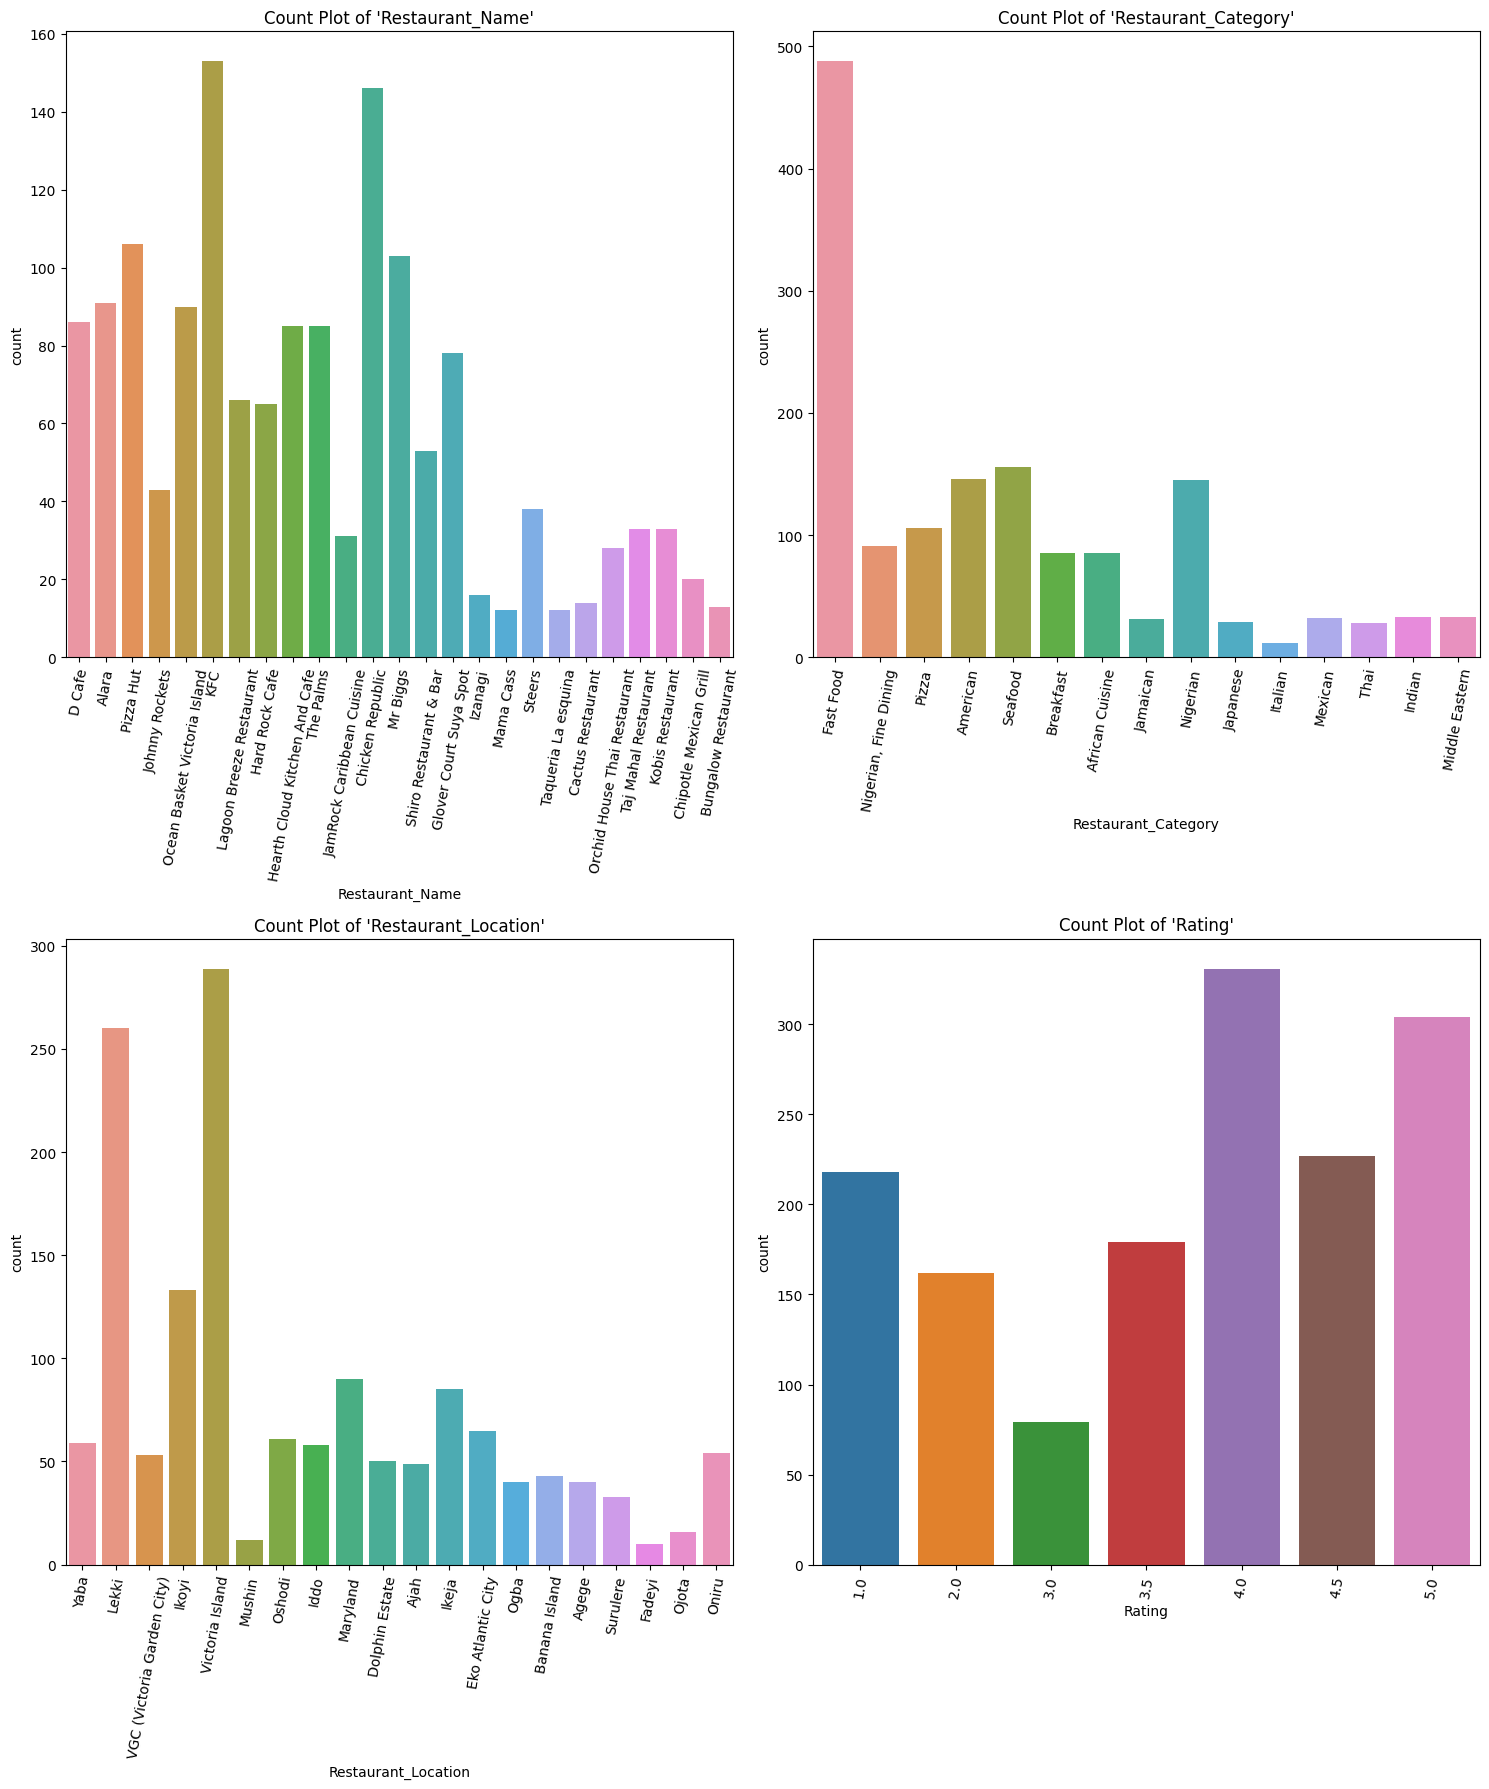

In [ ]:
plot_counts(data=restaurant_df,features=categorical,n_rows=2,n_cols=2)

The following conclusions were made:
- KFC and Chicken Replubic ahve the most amount of orders
- The category with the highest orders are fast food followed by Seafood
- The restaurants were located mainly in Victoria Island and Lekki
- The plot shows a left skewed data with more of the rating being within the range of 4.0 to 5.0.

In [ ]:
#creating a function to plot numerical variables
## Histogram function
def plot_histogram(*, data: pd.DataFrame, feature: str) -> "Plot":
    """This returns a Seaborn Histogram."""
    sns.histplot(data=data, x=feature)
    plt.title(f"Distribution of {feature!r}", size=16)
    plt.tight_layout()
    plt.show()

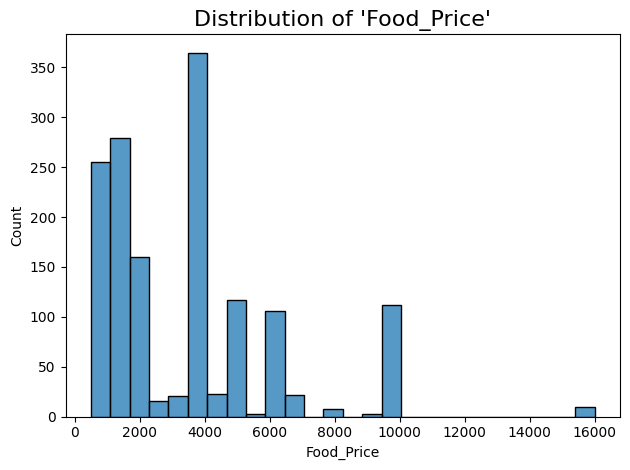

In [ ]:
plot_histogram(data=restaurant_df,feature="Food_Price")

The plot indicates that the food price with the greatest number of occurrences is between 3700 and 4000, meaning a large percentage of foods are between the price of 3700 and 4000

#### Are Pricing and Rating Related
To find the correlation between Pricing and Rating, we plot a correlation matrix

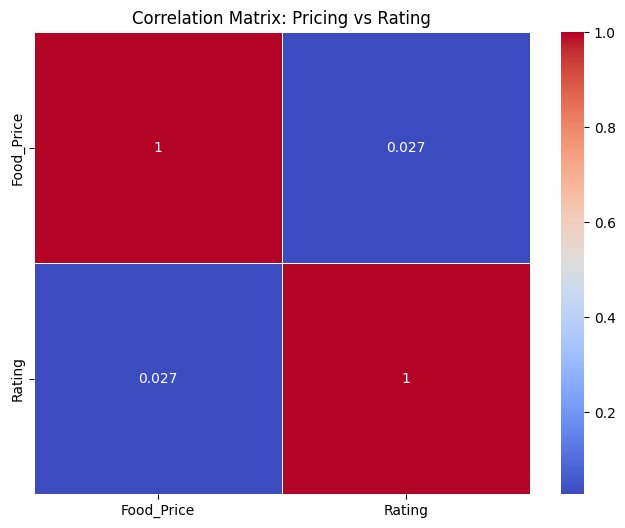

In [ ]:
# Compute the correlation matrix
correlation_matrix = restaurant_df[['Food_Price', 'Rating']].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix: Pricing vs Rating')
plt.show()

This matrix shows that the price of items and the rating are not correlated.

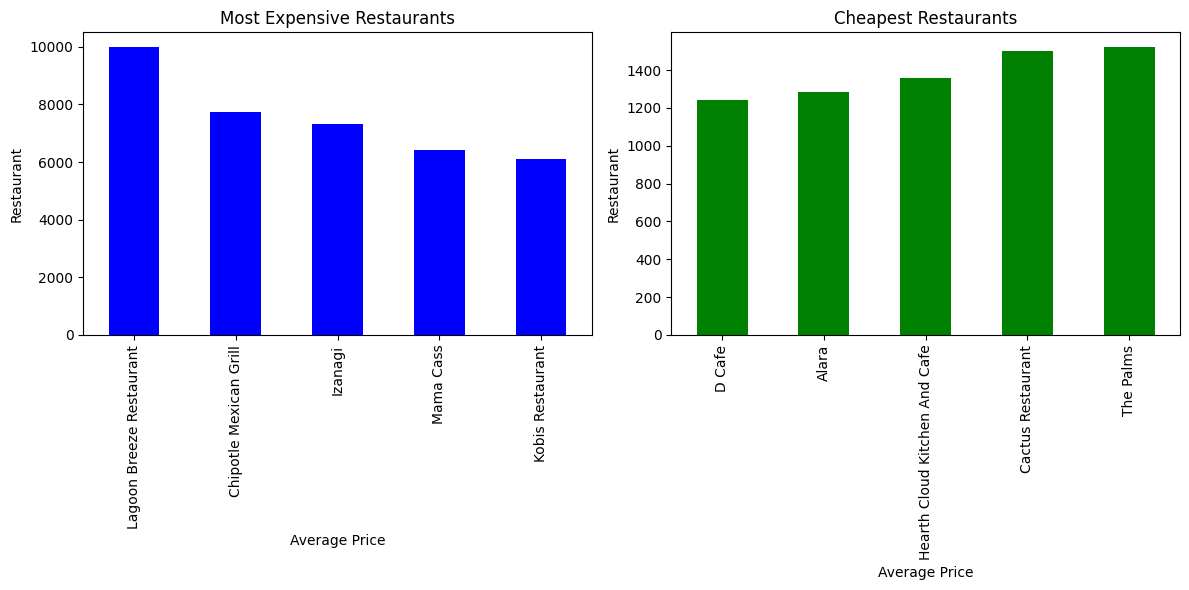

In [ ]:

# Calculate the average price for each restaurant
restaurant_prices = restaurant_df.groupby('Restaurant_Name')['Food_Price'].mean()

# Sort the restaurants based on average price in descending order for most expensive
most_expensive_restaurants = restaurant_prices.sort_values(ascending=False).head()

# Sort the restaurants based on average price in ascending order for cheapest
cheapest_restaurants = restaurant_prices.sort_values().head()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the most expensive restaurants
most_expensive_restaurants.plot(kind='bar', ax=ax1, color='blue')
ax1.set_title('Most Expensive Restaurants')
ax1.set_xlabel('Average Price')
ax1.set_ylabel('Restaurant')

# Plot the cheapest restaurants
cheapest_restaurants.plot(kind='bar', ax=ax2, color='green')
ax2.set_title('Cheapest Restaurants')
ax2.set_xlabel('Average Price')
ax2.set_ylabel('Restaurant')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


### Feature Engineering
Creating the Food_Id columns for every unique meal

In [ ]:
distinct_food_names = restaurant_df['Food_name'].unique()

# Create a new column "Food_ID" starting from 1
restaurant_df['Food_ID'] = pd.factorize(restaurant_df['Food_name'])[0] + 1


## Recommender Systems
Recommender systems are widely used in various industries to provide personalized recommendations to users. These systems utilize data analysis and machine learning techniques to predict and suggest items that users might find interesting or useful. The main goal of a recommender system is to enhance user experience, increase engagement, and drive customer satisfaction.


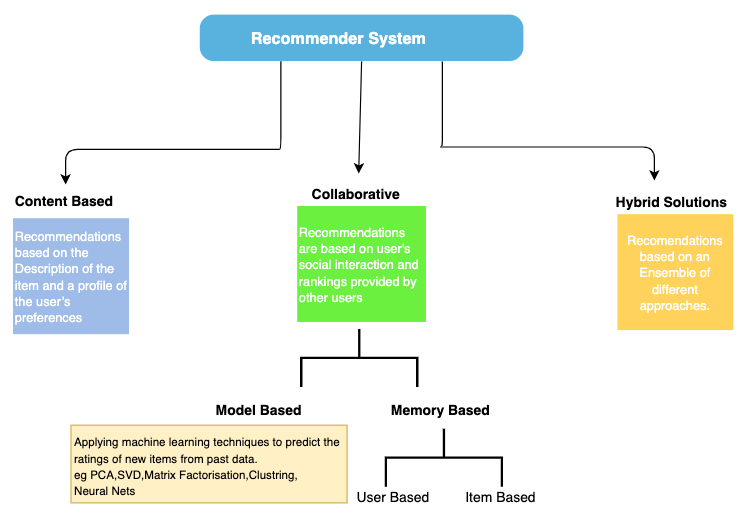


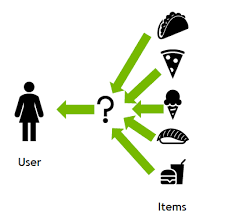

Recommender systems can be classified into different types based on their approaches:

- Collaborative Filtering: This approach focuses on finding similarities between users or items based on their past behaviors or preferences. It recommends items to a user based on the preferences of similar users or the user's own past behavior.

- Content-Based Filtering: This approach recommends items to a user based on the characteristics or attributes of the items themselves. It analyzes the content or features of items that the user has liked or interacted with and suggests similar items.

- Hybrid Approaches: Hybrid recommender systems combine multiple techniques, such as collaborative filtering and content-based filtering, to provide more accurate and diverse recommendations. These systems leverage the strengths of different approaches to overcome their limitations.

### Calculation of Weighted Average for Popular Restaurants
In order to determine the most popular restaurants based on the given dataset, we performed a calculation of the weighted average. The weighted average takes into account the ratings and the weight assigned to each restaurant, which is derived from either the count of orders or the count of ratings.

In [ ]:

# Calculate the weight for each restaurant (count of orders or ratings)
restaurant_weights = restaurant_df['Restaurant_Name'].value_counts()

# Calculate the weighted average for each restaurant
restaurant_df['Weighted_Rating'] = restaurant_df['Rating'] * restaurant_df['Restaurant_Name'].map(restaurant_weights)

# Calculate the sum of weighted ratings and sum of weights for each restaurant
grouped_data = restaurant_df.groupby('Restaurant_Name').agg({'Weighted_Rating': 'sum', 'Restaurant_Name': 'size'})

# Calculate the weighted average for each restaurant
grouped_data['Weighted_Average'] = grouped_data['Weighted_Rating'] / grouped_data['Restaurant_Name']

# Sort the restaurants based on their weighted average in descending order
popular_restaurants = grouped_data.sort_values('Weighted_Average', ascending=False)

# Print the most popular restaurants
popular_restaurants[['Weighted_Rating','Weighted_Average']].head()


,Weighted_Rating,Weighted_Average
Restaurant_Name,,
KFC,81166.5,530.5
Chicken Republic,72562.0,497.0
Pizza Hut,42029.0,396.5
Mr Biggs,37955.5,368.5
D Cafe,28423.0,330.5


### Calculation of Weighted Average for Popular Meals
In order to determine the most popular meals based on the given dataset, we performed a calculation of the weighted average. The weighted average takes into account the ratings and the weight assigned to each meal, which is derived from either the count of orders or the count of ratings. The ouput prints out the 5 most popular meals, the restaurant associated with it and the weighted average

In [ ]:
# Calculate the weighted average for each meal
grouped_data = restaurant_df.groupby(['Food_name', 'Restaurant_Name']).agg({'Rating': 'mean', 'Food_name': 'count'})
grouped_data.columns = ['Average_Rating', 'Order_Count']

# Assign weights based on the order count or rating count
weights = grouped_data['Order_Count']  # Use order count as weights
# weights = grouped_data['Rating']  # Use rating count as weights

# Calculate the weighted average
grouped_data['Weighted_Average'] = grouped_data['Average_Rating'] * weights

# Sort the meals based on their weighted average in descending order
popular_meals = grouped_data.sort_values('Weighted_Average', ascending=False)

# Reset the index to separate the multi-index columns
popular_meals = popular_meals.reset_index()

# Print the most popular meals with restaurant name
popular_meals[['Food_name', 'Restaurant_Name', 'Weighted_Average']].head()


,Food_name,Restaurant_Name,Weighted_Average
0,Seafood Platter,Lagoon Breeze Restaurant,240.5
1,French Fries,D Cafe,195.5
2,Grilled Fish with Lemon Butter Sauce,Ocean Basket Victoria Island,193.5
3,Chicken Alfredo,KFC,167.5
4,Moi Moi,Alara,162.5


#### Category Based Filtering

The following function, recommend_similar, is designed to provide recommendations for similar restaurants and meals based on a weighted rating formula. It takes a category of restaurants as input and returns a list of qualified recommendations

In [ ]:
def recommend_similar(category:str, percentile=0.85):
    df = restaurant_df[restaurant_df['Restaurant_Category'] == category]
    vote_counts = df[df['Rating'].notnull()]['Rating'].astype('int')
    vote_averages = df[df['Rating'].notnull()]['Rating'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)

    qualified = df[(df['Rating'] >= m) & (df['Rating'].notnull()) & (df['Food_Price'].notnull())][['Restaurant_Name', 'Food_name', 'Rating', 'Food_Price', 'Restaurant_Location']]
    qualified['Rating'] = qualified['Rating'].astype('int')
    qualified['Food_price'] = qualified['Food_Price'].astype('int')

    qualified['wr'] = qualified.apply(lambda x: (x['Rating']/(x['Rating']+m) * x['Food_Price']) + (m/(m+x['Rating']) * C), axis=1)
    return qualified[['Restaurant_Name', 'Food_name', 'Rating', 'Food_Price', 'Restaurant_Location']].head()

    return qualified


To use this function, simply provide the desired restaurant category as the input parameter. The function will then generate a list of similar restaurants and meals, sorted by their weighted rating.

In [ ]:
## Testing the recommed_similar function
recommend_similar("Fast Food")

,Restaurant_Name,Food_name,Rating,Food_Price,Restaurant_Location
0,D Cafe,Onion Rings,5,1000,Yaba
8,KFC,Chicken Bucket,5,4860,VGC (Victoria Garden City)
33,D Cafe,Onion Rings,5,1000,VGC (Victoria Garden City)
46,Chicken Republic,Chicken Adobo Rice,5,3500,Surulere
67,KFC,Chicken Alfredo,5,4000,Maryland


The below function detects the text and compares it to the category column, allowing it to detect similar foods

In [ ]:

def recommend_similar_with_text(input_text: str, percentile=0.85):
    df = restaurant_df
    vote_counts = df[df['Rating'].notnull()]['Rating'].astype('int')
    vote_averages = df[df['Rating'].notnull()]['Rating'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)

    qualified = df[(df['Rating'] >= m) & (df['Rating'].notnull()) & (df['Food_Price'].notnull())][['Restaurant_Name', 'Food_name', 'Rating', 'Food_Price', 'Restaurant_Location','Restaurant_Category']]
    qualified['Rating'] = qualified['Rating'].astype('int')
    qualified['Food_price'] = qualified['Food_Price'].astype('int')

    qualified['wr'] = qualified.apply(lambda x: (x['Rating']/(x['Rating']+m) * x['Food_Price']) + (m/(m+x['Rating']) * C), axis=1)

    # Filter qualified results based on similarity to input text in the category column
    qualified['Similarity'] = qualified['Restaurant_Category'].apply(lambda x: bool(re.search(input_text, x, re.IGNORECASE)))
    recommended = qualified[qualified['Similarity'] == True]

    return recommended[['Restaurant_Name', 'Food_name', 'Rating', 'Food_Price', 'Restaurant_Location']].head()


In [ ]:
#testing the function
recommend_similar_with_text("Nigeria")

,Restaurant_Name,Food_name,Rating,Food_Price,Restaurant_Location
15,Alara,Moi Moi,5,1000,Lekki
152,Alara,Ayamase Stew with Eba,5,1600,Lekki
153,Glover Court Suya Spot,Fried Plantains,5,2000,Ikoyi
164,Alara,Ayamase Stew with Eba,5,1600,Lekki
176,Shiro Restaurant & Bar,Egusi Soup with Pounded Yam,5,2500,Victoria Island


### Content Based Filtering

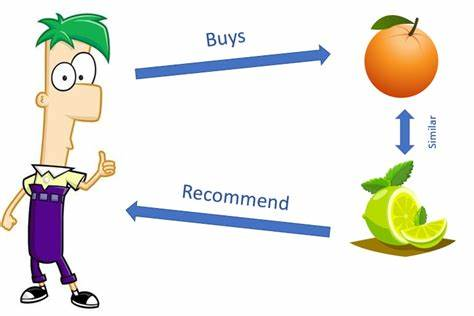
In this recommender system the description of the meal, The Restaurant Name and its categoty is used to find its similarity with other meals. Then the meals that are most likely to be similar are recommended.

##### Description Based Recommemder
This code implements a description-based recommender system using the concept of cosine similarity. Given a food name as input, the recommender system suggests similar foods based on their food descriptions.

In [ ]:
def recommend_similar_foods(food_name:str):
    # Create a TF-IDF Vectorizer object and fit-transform the food description column
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(restaurant_df['Food_Description'].unique())

    # Compute the cosine similarity matrix
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    # Get the index of the food in the dataset based on the food name
    food_index = restaurant_df[restaurant_df['Food_name'] == food_name].index[0]

    # Get the pairwise similarity scores for the food
    food_sim_scores = list(enumerate(cosine_sim[food_index]))

    # Sort the similarity scores
    food_sim_scores = sorted(food_sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the top 5 similar foods
    similar_indices = [i[0] for i in food_sim_scores[1:6]]

    # Get the names of the recommended similar foods
    recommended_foods = restaurant_df[['Food_name', 'Restaurant_Name']].iloc[similar_indices]

    return recommended_foods


To recommend foods similar to Green Curry based on Description

In [ ]:
recommend_similar_foods("Green Curry")

,Food_name,Restaurant_Name
23,Chicken Bucket,KFC
62,Onion Rings,D Cafe
14,Fries,Johnny Rockets
76,Chicken Pie,Mr Biggs
15,Moi Moi,Alara


To recommend foods similar to Chicken Alfredo based on Description

In [ ]:
recommend_similar_foods("Chicken Alfredo")

,Food_name,Restaurant_Name
8,Chicken Bucket,KFC
71,Shrimp Scampi Pasta,Ocean Basket Victoria Island
58,Fries,Steers
69,Green Curry,Orchid House Thai Restaurant
32,Pizza,Mama Cass


This method of recommnedation is not very reliable

##### Combining Restaurant Category, Loaction and Descritption
This code combines the restaurant location, food description, and restaurant category into a single string and uses it to compute the TF-IDF matrix and cosine similarity matrix. The pairwise similarity scores are obtained based on the input food name, and the top 5 similar foods are returned as recommendations.

In [ ]:
def recommend_similar_foodswith_FDLC(food_name: str):
    # Create a TF-IDF Vectorizer object and fit-transform the combined columns
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(restaurant_df['Restaurant_Location'] + ' ' + restaurant_df['Food_Description'] + ' ' + restaurant_df['Restaurant_Category'])

    # Compute the cosine similarity matrix
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    # Get the index of the food in the dataset based on the food name
    food_index = restaurant_df[restaurant_df['Food_name'] == food_name].index[0]

    # Get the pairwise similarity scores for the food
    food_sim_scores = list(enumerate(cosine_sim[food_index]))

    # Sort the similarity scores
    food_sim_scores = sorted(food_sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the top 5 similar foods
    similar_indices = [i[0] for i in food_sim_scores[1:6]]

    # Get the names of the recommended similar foods
    recommended_foods = restaurant_df[['Food_name', 'Restaurant_Name']].iloc[similar_indices]

    return recommended_foods


To recommend foods similar to Chicken Alfredo based on Description, Location and Category

In [ ]:
recommend_similar_foodswith_FDLC("Chicken Alfredo")

,Food_name,Restaurant_Name
448,Chicken Alfredo,KFC
508,Chicken Alfredo,KFC
703,Chicken Alfredo,KFC
494,Chicken Alfredo,KFC
817,Chicken Alfredo,KFC


The output seems to be the same as with only description, hence not very relaible

### Price and Rating Based Recommender
The modified function food_recommendationsss takes a food_name as input and provides recommendations based on the average price and average rating for the meal. Here's how the function works:

In [ ]:
def food_recommendationsss(food_name: str):
    # Filter the restaurant dataset based on the food name
    filtered_restaurants = restaurant_df[restaurant_df['Food_name'] == food_name]

    # Calculate the average price and rating for the food name
    avg_price = filtered_restaurants['Food_Price'].mean()
    avg_rating = filtered_restaurants['Rating'].mean()

    # Create a TF-IDF Vectorizer object and fit-transform the food name column
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(restaurant_df['Food_name'].unique())

    # Compute the cosine similarity matrix
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    # Get the index of the food in the dataset based on the food name
    idx = restaurant_df[restaurant_df['Food_name'] == food_name].index[0]

    # Get the pairwise similarity scores for the food
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the top 25 similar foods
    food_indices = [i[0] for i in sim_scores[1:26]]

    # Filter the restaurant dataset based on the selected food indices
    recommended_restaurants = restaurant_df.iloc[food_indices].copy()

    # Calculate the difference between the average price and rating of each recommended restaurant
    recommended_restaurants['Price_diff'] = abs(recommended_restaurants['Food_Price'] - avg_price)
    recommended_restaurants['Rating_diff'] = abs(recommended_restaurants['Rating'] - avg_rating)

    # Sort the recommended restaurants based on the difference in average price and rating
    recommended_restaurants = recommended_restaurants.sort_values(['Price_diff', 'Rating_diff'], ascending=[True, True])

    # Select the relevant columns for the recommendations
    recommended_restaurants = recommended_restaurants[['Restaurant_Name', 'Food_name', 'Food_Price', 'Restaurant_Location']]

    return recommended_restaurants.head(5)


To recommend foods similar to Chicken Alfredo based on Price and Ratings

In [ ]:
food_recommendationsss("Chicken Alfredo")

,Restaurant_Name,Food_name,Food_Price,Restaurant_Location
12,KFC,Chicken Alfredo,4000,Iddo
37,Steers,Steak,4000,Banana Island
67,KFC,Chicken Alfredo,4000,Maryland
7,Pizza Hut,Chicken Supreme Pizza,4100,Mushin
57,Pizza Hut,Pepperoni Pizza,3500,Surulere


While the recommender system has provided some suggestions, it appears that the recommendations are somewhat similar to the input food item.

#### Price, Rating,Location, Description and Category Based recommender
Now the recommend_similar_foods function takes the food name as input, and it considers the average price and rating for the food name, as well as incorporates the restaurant location, food description, and restaurant category into the cosine similarity matrix. The recommended restaurants are sorted based on the difference in average price and rating, and the top 5 recommendations are returned.

In [ ]:
def recommend_similar_foods_with_TLC(food_name: str):
    # Filter the restaurant dataset based on the food name
    restaurant_dfs=restaurant_df.drop(columns='User_ID')
    restaurant_dfs=restaurant_dfs.drop_duplicates(['Restaurant_Name','Restaurant_Location'])
    filtered_restaurants = restaurant_dfs[restaurant_dfs['Food_name'] == food_name]

    # Calculate the average price and rating for the food name
    avg_price = filtered_restaurants['Food_Price'].mean()
    avg_rating = filtered_restaurants['Rating'].mean()

    # Create a TF-IDF Vectorizer object and fit-transform the combined columns
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(restaurant_dfs['Restaurant_Location'] + ' ' + restaurant_dfs['Food_Description'] + ' ' + restaurant_dfs['Restaurant_Category'])

    # Compute the cosine similarity matrix
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    # Get the index of the food in the dataset based on the food name
    food_index = restaurant_dfs[restaurant_dfs['Food_name'] == food_name].index[0]

    # Get the pairwise similarity scores for the food
    food_sim_scores = list(enumerate(cosine_sim[food_index]))

    # Sort the similarity scores
    food_sim_scores = sorted(food_sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the top 5 similar foods
    similar_indices = [i[0] for i in food_sim_scores[1:500]]

    # Filter the restaurant dataset based on the selected food indices
    recommended_restaurants = restaurant_dfs.iloc[similar_indices].copy()

    # Calculate the difference between the average price and rating of each recommended restaurant
    recommended_restaurants['Price_diff'] = abs(recommended_restaurants['Food_Price'] - avg_price)
    recommended_restaurants['Rating_diff'] = abs(recommended_restaurants['Rating'] - avg_rating)

    # Sort the recommended restaurants based on the difference in average price and rating
    recommended_restaurants = recommended_restaurants.sort_values(['Price_diff', 'Rating_diff'], ascending=[True, True])

    # Select the relevant columns for the recommendations
    recommended_restaurants = recommended_restaurants[['Restaurant_Name', 'Food_name', 'Food_Price', 'Restaurant_Location']]

    return recommended_restaurants.head(5)


To recommend foods similar to Chicken Alfredo based on Price and Ratings,Location,Category and Description

In [ ]:
recommend_similar_foods_with_TLC("Chicken Alfredo")

,Restaurant_Name,Food_name,Food_Price,Restaurant_Location
993,Steers,Steak,4000,VGC (Victoria Garden City)
21,JamRock Caribbean Cuisine,Jerk Chicken,4000,Yaba
106,Pizza Hut,Cheese Pizza,4000,Yaba
311,JamRock Caribbean Cuisine,Jerk Chicken,4000,Dolphin Estate
186,Pizza Hut,Cheese Pizza,4000,Oniru


Based on this output, it appears that the recommendations are not significantly different from the original food item "Chicken Alfredo". The food names and prices are quite similar, and the recommended restaurants are also not diverse. Therefore, the current recommendation system may need further improvements to provide more varied and distinct suggestions.

### Collaborative Filtering


Collaborative filtering is a popular technique in recommendation systems that utilizes the collective behavior and preferences of users to make personalized recommendations. It is based on the idea that users with similar tastes and preferences in the past will have similar preferences in the future.

Collaborative filtering operates by analyzing user-item interactions or feedback data to identify patterns and make predictions about user interests. It can be broadly categorized into two types: user-based collaborative filtering and item-based collaborative filtering.

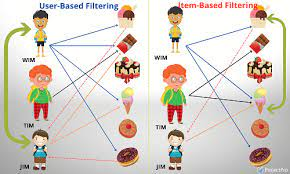

#### User-Based Recommended System

In [ ]:
reader = Reader()
ratings = pd.read_csv('restaurant_datas.csv')
ratings.head()

,User_ID,Food_name,Restaurant_Name,Food_Price,Restaurant_Category,Rating,Food_Description,Restaurant_Location
0,410357,Onion Rings,D Cafe,1000,Fast Food,5.0,A popular side dish made with onions that have...,Yaba
1,410375,Moi Moi,Alara,1000,"Nigerian, Fine Dining",4.0,Moi Moi is a savory Nigerian steamed bean pudd...,Lekki
2,410384,Pepperoni Pizza,Pizza Hut,3500,Pizza,5.0,This classic pizza is made with a tomato sauce...,VGC (Victoria Garden City)
3,410168,Root Beer Float,Johnny Rockets,5000,American,2.0,A root beer float is a classic American treat ...,Ikoyi
4,410402,Grilled Fish with Lemon Butter Sauce,Ocean Basket Victoria Island,3500,Seafood,2.0,Freshly grilled fish fillet topped with a zest...,Victoria Island


In [ ]:
distinct_food_names = ratings['Food_name'].unique()

# Create a new column "Food_ID" starting from 1
ratings['Food_ID'] = pd.factorize(ratings['Food_name'])[0] + 1
ratings_df=ratings[['User_ID','Food_ID','Rating']]

In [ ]:

# Load the dataset and create the reader
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[['User_ID', 'Food_ID', 'Rating']], reader)

# Create the SVD model
svd = SVD()

# Perform cross-validation
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

# Print the average RMSE and MAE scores
print("Average RMSE:", results['test_rmse'].mean())
print("Average MAE:", results['test_mae'].mean())


Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.3933  1.3279  1.4149  1.3787  0.0370  
MAE (testset)     1.1682  1.0853  1.1696  1.1410  0.0394  
Fit time          0.03    0.03    0.04    0.03    0.00    
Test time         0.01    0.01    0.02    0.01    0.01    
Average RMSE: 1.3786732028837363
Average MAE: 1.14103985705977


In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
svd.predict(410375, 10, 3)


Prediction(uid=410375, iid=10, r_ui=3, est=4.097928450209998, details={'was_impossible': False})

Based on the collaborative filtering model (SVD), the predicted rating for a user with the ID 410375 and a food with the ID 10 is 3.86. This prediction is based on the user's historical preferences and the similarity of this food to other items in the dataset. The "was_impossible" attribute indicates that the prediction was possible to generate.

Please note that this predicted rating is an estimation and may not perfectly align with the user's actual preference. It serves as a recommendation and should be considered alongside other factors when making decisions related to food selection or recommendation.

### Hybrid Recommender

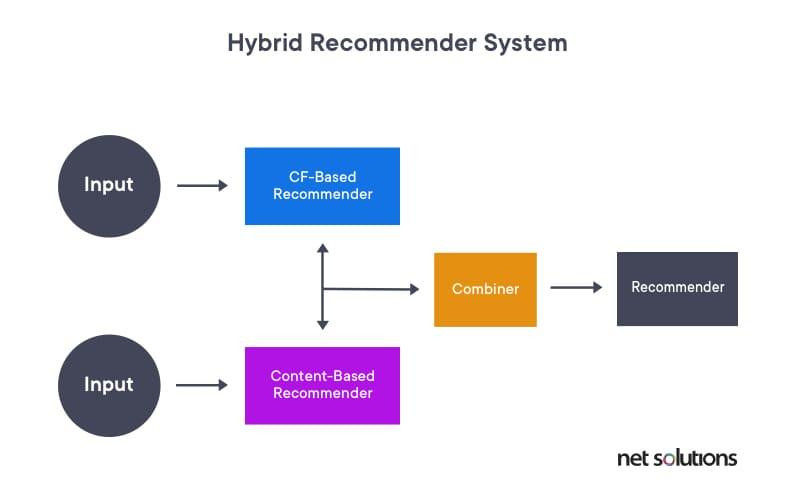

In this section, I will try to build a simple hybrid recommender that brings together techniques we have implemented in the content based and collaborative filter based engines. This is how it will work:

- Input: User ID and the Category
- Output: Similar foods sorted on the basis of expected ratings by that particular user.

But first we will identify the highest rated order for each user in the dataset. This will help us understand the most preferred food items by each user.

In [ ]:
# Find the highest rated order for each user
max_ratings = ratings.groupby('User_ID')['Rating'].transform(max) == ratings['Rating']
highest_rated_user = ratings[max_ratings]

# Print the dataset
highest_rated_user

,User_ID,Food_name,Restaurant_Name,Food_Price,Restaurant_Category,Rating,Food_Description,Restaurant_Location,Food_ID
0,410357,Onion Rings,D Cafe,1000,Fast Food,5.0,A popular side dish made with onions that have...,Yaba,1
2,410384,Pepperoni Pizza,Pizza Hut,3500,Pizza,5.0,This classic pizza is made with a tomato sauce...,VGC (Victoria Garden City),3
7,41001,Chicken Supreme Pizza,Pizza Hut,4100,Pizza,5.0,"This pizza is made with a tomato sauce base, m...",Mushin,7
8,410205,Chicken Bucket,KFC,4860,Fast Food,5.0,"Fried chicken coated in a crispy batter, serve...",VGC (Victoria Garden City),8
10,410408,Classic Cheeseburger with Fries,Hard Rock Cafe,2000,American,5.0,"A juicy beef patty topped with cheese, lettuce...",Victoria Island,10
...,...,...,...,...,...,...,...,...,...
1490,410316,Chicken Bucket,KFC,4860,Fast Food,2.0,"Fried chicken coated in a crispy batter, serve...",VGC (Victoria Garden City),8
1491,410417,Chicken Alfredo,KFC,4000,Fast Food,5.0,"Chicken in a creamy Alfredo sauce, served over...",Oshodi,6
1494,410163,Jollof Rice,Glover Court Suya Spot,4000,Nigerian,4.0,"Jollof rice, a popular Nigerian rice dish.",Maryland,35
1496,410417,Spicy Chicken Burger,Chicken Republic,1000,Fast Food,5.0,This burger is made with a chicken patty that ...,Oniru,52


The highest_rated_user dataset provides valuable insights into the food preferences of each user based on their highest rated orders.

In [ ]:
def hybrid(userId: int, category: str):
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(highest_rated_user['Restaurant_Location'] + ' ' + highest_rated_user['Food_Description'] + ' ' + highest_rated_user['Restaurant_Category'])

    # Compute the cosine similarity matrix
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    # Get the index of the food in the dataset based on the food category
    food_index = highest_rated_user[highest_rated_user['Restaurant_Category'] == category].index[0]

    # Get the pairwise similarity scores for the food
    food_sim_scores = list(enumerate(cosine_sim[food_index]))
    sim_scores = sorted(food_sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    rest_indices = [i[0] for i in sim_scores]

    # Get the recommended foods
    recommended_foods = highest_rated_user.iloc[rest_indices][['User_ID', 'Restaurant_Name', 'Food_name', 'Food_Price', 'Restaurant_Location']]
    recommended_foods['est'] = recommended_foods['User_ID'].apply(lambda x: svd.predict(userId, x).est)
    recommended_foods = recommended_foods.sort_values('est', ascending=False).drop_duplicates(subset=["Restaurant_Location",'Food_Price'],keep='first')

    return recommended_foods[[ 'Restaurant_Name', 'Food_name', 'Food_Price', 'Restaurant_Location']].head(5)


In [ ]:
hybrid(410180,'Fast Food')

,Restaurant_Name,Food_name,Food_Price,Restaurant_Location
1036,D Cafe,Onion Rings,1000,Maryland
790,Mr Biggs,Chicken Fingers,6000,Yaba
1241,Mr Biggs,Chicken Fingers,6000,Lekki
1384,D Cafe,French Fries,1400,Lekki
433,D Cafe,French Fries,1400,Yaba


In [ ]:
hybrid(410417,'Fast Food')

,Restaurant_Name,Food_name,Food_Price,Restaurant_Location
1036,D Cafe,Onion Rings,1000,Maryland
790,Mr Biggs,Chicken Fingers,6000,Yaba
1241,Mr Biggs,Chicken Fingers,6000,Lekki
1384,D Cafe,French Fries,1400,Lekki
433,D Cafe,French Fries,1400,Yaba


In this section, we will build a hybrid recommender that combines techniques from both the content-based and collaborative filtering approaches. The goal is to provide personalized food recommendations to users based on their preferences and similarities with other users.
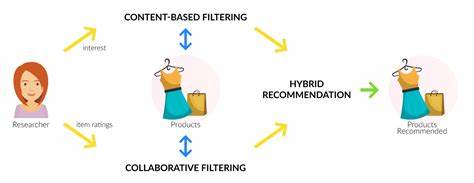

###### How it works
- Content-Based Filtering:

We start by creating a TF-IDF matrix using the textual features of the restaurants, such as the location, food description, and category.
Using this matrix, we compute the cosine similarity between each pair of restaurants.
Given a user's preference for a specific food category, we identify the index of a food item in the dataset that belongs to that category.
We calculate the pairwise similarity scores between the chosen food item and all other food items based on the cosine similarity matrix.
Selecting the top similar food items, we create a list of recommended foods.
- Collaborative Filtering:

Next, we leverage collaborative filtering to consider the preferences and ratings of similar users.
For each user, we calculate their similarity with other users based on their rated food items.
From the list of similar users, we select the most similar ones and retrieve their food preferences and ratings.
Using this information, we estimate the expected ratings for the food items not yet rated by the target user.
We sort the food items based on the estimated ratings in descending order.
- Hybridization:

Finally, we merge the results from the content-based filtering and collaborative filtering approaches.
We sort the recommended food items based on the estimated ratings to prioritize the most highly rated options.
To avoid recommending duplicate food items with the same price and location, we remove duplicates while keeping the first occurrence.

In [ ]:
def hybrid_id(userId: int):
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(highest_rated_user['Restaurant_Location'] + ' ' + highest_rated_user['Food_Description'] + ' ' + highest_rated_user['Restaurant_Category'])

    # Compute the cosine similarity matrix
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    # Get the index of the user in the dataset based on the user ID
    user_index = highest_rated_user[highest_rated_user['User_ID'] == userId].index[0]

    # Get the pairwise similarity scores for the user
    user_sim_scores = list(enumerate(cosine_sim[user_index]))
    sim_scores = sorted(user_sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    food_indices = [i[0] for i in sim_scores]

    # Get the recommended foods
    recommended_foods = highest_rated_user.iloc[food_indices][['User_ID', 'Restaurant_Name', 'Food_name', 'Food_Price', 'Restaurant_Location']]
    recommended_foods['est'] = recommended_foods['User_ID'].apply(lambda x: svd.predict(userId, x).est)
    recommended_foods = recommended_foods.sort_values('est', ascending=False).drop_duplicates(subset=["Restaurant_Location",'Food_Price'],keep='first')

    return recommended_foods[['Restaurant_Name', 'Food_name', 'Food_Price', 'Restaurant_Location']].head(5)


The  dataframe will contain the top recommended food items for the user with ID 41001.

In [ ]:
hybrid_id(41001)

,Restaurant_Name,Food_name,Food_Price,Restaurant_Location
53,The Palms,Ogi,500,Lekki
176,Shiro Restaurant & Bar,Egusi Soup with Pounded Yam,2500,Victoria Island
892,The Palms,Nigerian Fried Rice,3500,Lekki
1335,Cactus Restaurant,Pounded Yam with Ogbono Soup,1500,Lekki


The  dataframe will contain the top recommended food items for the user with ID 410400.

In [ ]:
hybrid_id(410400)

,Restaurant_Name,Food_name,Food_Price,Restaurant_Location
226,The Palms,Akara (Bean Fritters),500,Lekki
1337,The Palms,Nigerian Fried Rice,3500,Lekki
15,Alara,Moi Moi,1000,Lekki


### Implementing pipelines







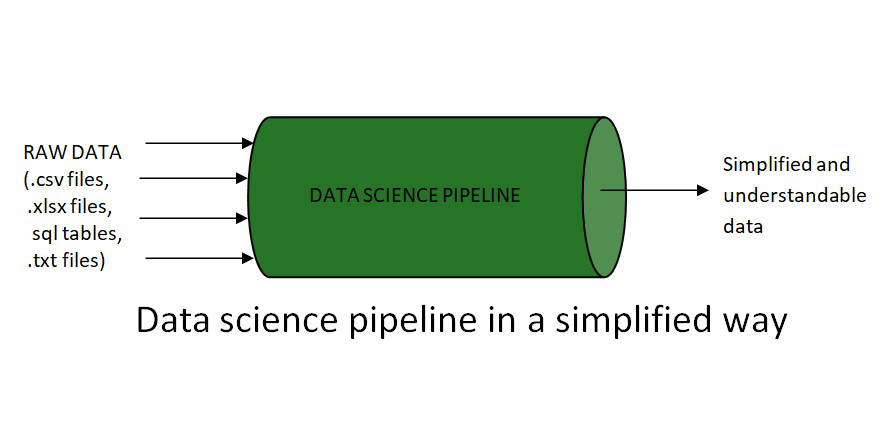

In the below code, we are creating a pipeline using scikit-learn's Pipeline class to apply the hybrid_id function to the highest_rated_user dataframe.

By calling pipeline.transform(highest_rated_user['User_ID']), the pipeline will invoke the hybrid_id function on each user ID in the highest_rated_user dataframe, and the resulting recommended foods will be stored in the recommended_foods variable.

To create an output where we can input the User_ID and get the list of recommended foods, you can define a separate function that uses the pipeline and accepts the username as an argument

In [ ]:

from sklearn.base import BaseEstimator, TransformerMixin

class HybridIDTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Apply the hybrid_id function
        recommended_foods = hybrid_id(X[0])

        # Convert the recommended_foods to a numpy array
        recommended_foods_array = recommended_foods.to_numpy()

        return recommended_foods_array

# Create the pipeline with the HybridIDTransformer
pipeline = Pipeline([
    ('hybrid', HybridIDTransformer())
])

# Example usage
userId = 41001
recommended_foods = pipeline.transform([userId])
df_recommended_foods = pd.DataFrame(recommended_foods, columns=['Restaurant_Name', 'Food_name', 'Food_Price', 'Restaurant_Location'])
df_recommended_foods

,Restaurant_Name,Food_name,Food_Price,Restaurant_Location
0,The Palms,Ogi,500,Lekki
1,Shiro Restaurant & Bar,Egusi Soup with Pounded Yam,2500,Victoria Island
2,The Palms,Nigerian Fried Rice,3500,Lekki
3,Cactus Restaurant,Pounded Yam with Ogbono Soup,1500,Lekki
